# Bert, Fine-tuning and PEFT Methods

In [1]:
from data_loader.data_loader import load_and_split_data

import torch as t
from rich.pretty import pprint
from datasets import load_dataset
import pandas as pd
import plotly.express as px
import time
from dataclasses import dataclass
from torchmetrics.classification import Accuracy, F1Score
from torchmetrics import MeanAbsoluteError
from tqdm import tqdm

# Step 1: Initial setup (seed + config)

In [2]:
@dataclass
class Config:
    batch_size: int
    model: str
    seed: int
    lr: float
    epochs: int
    lora_r: int
    lora_alpha: float
    device: str
    num_classes: int

# Determine the best available device
if t.cuda.is_available():
    device = "cuda"
elif t.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

config = Config(
    batch_size = 16,
    model = "microsoft/deberta-v3-large", # "bert-large-cased", # "google/flan-t5-small", # TODO: small has 80 million tokens, but we can do ablation study going up to 11B for xxl model: https://huggingface.co/google/flan-t5-xxl
    seed = 42,
    lr = 3e-5,
    epochs = 5,
    # For LoRA
    lora_r = 16,
    lora_alpha = 32,  # a common choice is alpha = 2 * rank
    device=device,
    num_classes=3
)

In [3]:
def set_seed(seed: int) -> None:
    import os
    import random

    import numpy as np

    np.random.seed(seed)
    random.seed(seed)
    t.manual_seed(seed)
    t.cuda.manual_seed(seed)
    t.mps.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


set_seed(config.seed)

Random seed set as 42


In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(config.model)
print(f"""
{tokenizer.name_or_path=}
{tokenizer.vocab_size=}
{tokenizer.model_max_length=}
""")


tokenizer.name_or_path='microsoft/deberta-v3-large'
tokenizer.vocab_size=128000
tokenizer.model_max_length=1000000000000000019884624838656



/Users/tnorlha/miniconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Model has to be loaded separately for each task we want it to perfom, since each task requires a specific "head" to be added to the model: https://huggingface.co/blog/how-to-generate.
Here, we need a classification head.

In [5]:
from transformers import AutoModelForSequenceClassification

# We will use this function later to reload the model from scratch
def load_blank_model(config, quantization_config=None):
    # Delete references to a previously loaded model
    if "optimizer" in globals():
        global optimizer
        del optimizer
    if "model" in globals():
        global model
        del model

    # Free up GPU memory
    t.cuda.empty_cache()

    model = AutoModelForSequenceClassification.from_pretrained(config.model, num_labels=config.num_classes, quantization_config=quantization_config)
    model.to(config.device)

    return model


model = load_blank_model(config)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 is an encoder-decoder model, unlike BERT (which is encoder-only) and GPT (which is decoder-only).

One slight advantage is that in an encoder-decoder model the encodings are only computed once (in the encoder pass) and then the decoder is ran autoregressively, while in a GPT-style model, the prompt is essentially re-encoded in each step. This can be solved with caching, though.

Since T5 is encoder-decoder, the cross attention in the decoder has queries based on the decoder inputs and keys+values based on the encoder encodings.


---

Some of your tasks might be okay with just BERT (or rather, Electra / RoBERTa) or T5, others will require bigger models, like Llama. There are a lot of resources comparing different options here, a good one is [chatbot arena](https://chat.lmsys.org/) or [papers with code](https://paperswithcode.com/sota). Generally, Mistral seems to be consistently very good for its size and it is supported by HuggingFace.

Watch out, some of the models have base and instruction-tuned versions (e.g. Llama and Vicuna, respecively), the latter being RLHFed to follow instructions and answer questions, while the former behaves more like a traditional text completion model — think ChatGPT vs GPT-3.


 # Step 2: Loading the Dataset

In [6]:
train_df, eval_df = load_and_split_data()

def run_trainer_and_log(id, trainer, results):
    start = time.time()
    trainer.train()
    end = time.time()

    result = {
        "model": id,
        "params": trained_params_ratio(trainer.model),
        "time": end - start,
        "score": trainer.evaluate()["eval_accuracy"],
    }

    return log_result(result, results)


def log_result(result, results):
    return results + [result]

def trained_params_ratio(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(
        p.numel() for p in model.parameters()
    )


def plot_results(data: list[dict]):
    df = pd.DataFrame(data).melt(
        id_vars=["model", "score"],
        value_vars=["time", "params"],
        var_name="complexity",
        value_name="value",
    )

    fig = px.scatter(
        df,
        x="value",
        y="score",
        color="model",
        facet_col="complexity",
        title="Performance v. Parameters (top-right is best)",
        labels={
            "model": "Model",
            "value": "Complexity Metric (right = lower)",
            "score": "Accuracy on Eval Set"
        }
    )
    fig.update_xaxes(autorange="reversed", matches=None)
    fig.update_yaxes(range=[-0.1, 1.1])

    return fig

In [7]:
train_df.head(3)

,text,labels
id,,
90962,I have had a serious fear of dentists for as l...,-1
28024,"The pepper and onion shrimp was fried, and sti...",1
36538,The guy who was making my sushi (sai) was no e...,0


## Training Distribution

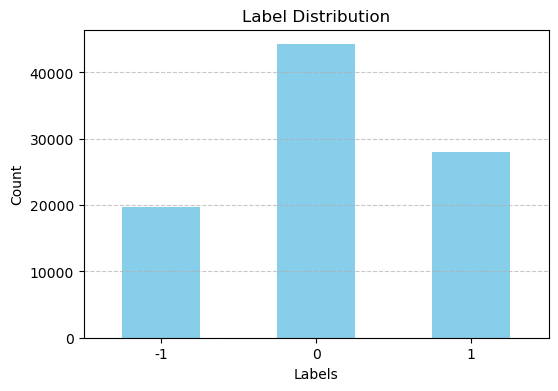

labels
-1    19719
 0    44233
 1    27935
Name: count, dtype: int64

Class distribution (percent):
labels
-1    21.46
 0    48.14
 1    30.40
Name: count, dtype: float64


In [8]:
from visualizations.visualizations import plot_label_distribution
plot_label_distribution(train_df)

## Eval Distribution

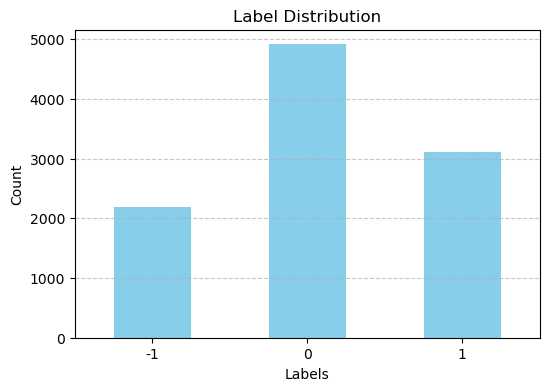

labels
-1    2191
 0    4915
 1    3104
Name: count, dtype: int64

Class distribution (percent):
labels
-1    21.46
 0    48.14
 1    30.40
Name: count, dtype: float64


In [9]:
plot_label_distribution(eval_df)

In [10]:
# [Pure PyTorch data loading 1/2]

import torch.utils.data as td

class ReviewDataset(td.Dataset):
    def __init__(self, df, with_labels=True):
        self.df = df
        self.with_labels = with_labels

    def __getitem__(self, index):
        row = self.df.iloc[index]
        output = {"text": row["text"]}
        if self.with_labels:
            output["labels"] = row["labels"]
        return output

    def __len__(self):
        return len(self.df)

dataset_pt_train = ReviewDataset(train_df)
dataset_pt_eval = ReviewDataset(eval_df)

pprint(dataset_pt_train[0], max_string=80)

{
│   'text': 'I have had a serious fear of dentists for as long as I remember and every time I'+73,
│   'labels': np.int64(-1)
}

In [11]:
# [Pure PyTorch data loading 2/2]

def tokenize_pt(examples):
    # batch is a list of dicts returned from the Dataset above, i.e. with keys
    # - text: str
    # - label: tensor of int

    texts = [x["text"] for x in examples]
    # The label type has to be Long for the metrics to work
    labels = t.Tensor([x["labels"] for x in examples]).long()

    # output is a dict with keys
    # - input_ids: list of list of int (each str got turned into list of tokens)
    # - attention_mask: list of int (1 means "meaningful token" as opposed to e.g. padding)
    # Without `return_tensors`, returns Python lists and dicts
    output = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")

    # all the token lists are padded to the same length
    lengths = set(len(t) for t in output["input_ids"])
    assert len(lengths) == 1

    # We don't inlcude the raw text here to save memory
    return output | { "labels": labels }

train_loader = td.DataLoader(dataset_pt_train, collate_fn=tokenize_pt, batch_size=config.batch_size)
eval_loader = td.DataLoader(dataset_pt_eval, collate_fn=tokenize_pt, batch_size=config.batch_size)

# The DataLoader has an inner iterator under __iter__
# through which you can access the generated batches
# It works the same way when you do for _ in loader: ...
pprint(next(train_loader.__iter__()))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{
│   'input_ids': tensor([[     1,    273,    286,    330,    266,   1721,   2189,    265,  19833,
│   │   │   270,    283,    455,    283,    273,   1221,    263,    469,    326,
│   │   │   273,    424,    270,    312,   4151,   1748,    807,    271,   1025,
│   │   │   278,   1015,    264,    282,   2687,    354,    262,    437,    326,
│   │   │   323,      2],
│   │   [     1,    279,   5883,    263,   8591,  11681,    284,   8996,    261,
│   │   │   263,    449,   9310,  16541,    335,    278,    519,    264,    351,
│   │   │   261,    273,    295,    364,   2755,    361,   1201,    278,    338,
│   │   │   282,    337,    273,   7965,    288,    262,   2213,    260,      2,
│   │   │     0,      0],
│   │   [     1,    279,   1863,    328,    284,    570,    312,  18147,    287,
│   │     31420,    285,    284,    363,   4704,    264,    291,    461,    260,
│   │   │     2,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0],
│   │   [     1,    573,   1745,    263,    273,    261,   3763,    264,    266,
│   │      1421,    272,    661,    261,   3537,    851,    260,    691,    260,
│   │   │     2,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0],
│   │   [     1,  15020,    444,    410,  10255,    323,      2,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0],
│   │   [     1,  11089,    270,    654,    275,   3775,    284,    314,    419,
│   │     24461,    260,      2,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0],
│   │   [     1,    279,   1983,   5586,  11536,    264,    262,    674,    265,
│   │     16342,  14054,    366,    304,    270,    370,    265,    262,    933,
│   │   │   278,    269,    657,    264,    848,    328,    269,  11796,    328,
│   │   │   289,    579,    323,      2,      0,      0,      0,      0,      0,
│   │   │     0,      0],
│   │   [     1,    273,    402,    681,    442,    315,   9165,    270,    262,
│   │   │   695,    740,    264,    365,    308,    688,   1660,    263,   1843,
│   │     17972,    260,      2,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0],
│   │   [     1,    369,    274,    286,   4444,    282,    521,    264,    556,
│   │   │   262,   2786,    779,    260,      2,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0],
│   │   [     1,   2821,    284,    397,    260,      2,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0],
│   │   [     1,    345,   3233,    266,   2181,   5548,    260,      2,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0,      0,      0,      0,      0,      0,      0,      0,
│   │   │     0,      0],
│   │   [     1,    273,    849,    758,    267,    308,  16749,    571,    263,
│   │   │   273,    280,    358,    890,  26465,  

In [12]:
# [HuggingFace data loading and tokenization 1/2]

from datasets import Dataset, DatasetDict
dataset_hf = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "eval": Dataset.from_pandas(eval_df)
})

pprint(dataset_hf["train"][0], max_string=80)

{
│   'text': 'I have had a serious fear of dentists for as long as I remember and every time I'+73,
│   'labels': -1,
│   'id': 90962
}

In [13]:
# [HuggingFace data loading and tokenization 2/2]

def tokenize_hf(examples):
    # examples is a dict with keys
    # - text: list of str
    # - label: list of int
    # created by the .map() function

    # output is a dict with keys
    # - input_ids: list of list of int (each str got turned into list of tokens)
    # - attention_mask: list of int (1 means "meaningful token" as opposed to e.g. padding)
    output = tokenizer(examples["text"], truncation=True, padding=True, max_length=100)

    # Notably, we DID NOT PAD the token sequences

    # The output dict is automatically spliced into the original inpu dict
    # i.e. {text, label} by .map()
    # Also, no need to cast to tensors, the HF Trainer will take care of that
    return output

# We map over both train and eval at the same time
tokenized_dataset: DatasetDict = dataset_hf.map(tokenize_hf, batched=True)

# Shuffle only the train dataset
dataset_hf_train: Dataset = tokenized_dataset["train"].shuffle(seed=config.seed)
dataset_hf_eval: Dataset = tokenized_dataset["eval"]

pprint(dataset_hf_train[:config.batch_size], max_string=80, max_length=5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/91887 [00:00<?, ? examples/s]

Map:   0%|          | 0/10210 [00:00<?, ? examples/s]

{
│   'text': [
│   │   "I've always been the guy to resist carrying punch cards and participating in sho"+88,
│   │   'After the massage she referred me to a chiropractor for  more information as the'+38,
│   │   'I agree with everybody!!!',
│   │   'We ordered take out tonight and when I called in the order, they said it would b'+22,
│   │   '"I\'m on my way.',
│   │   ... +11
│   ],
│   'labels': [1, 0, 0, 0, 1, ... +11],
│   'id': [86289, 54086, 55379, 61774, 64865, ... +11],
│   'input_ids': [
│   │   [1, 273, 280, 415, 489, ... +60],
│   │   [1, 643, 262, 5398, 373, ... +95],
│   │   [1, 273, 1757, 275, 4293, ... +83],
│   │   [1, 345, 3233, 413, 321, ... +65],
│   │   [1, 307, 476, 280, 358, ... +54],
│   │   ... +11
│   ],
│   'token_type_ids': [
│   │   [0, 0, 0, 0, 0, ... +60],
│   │   [0, 0, 0, 0, 0, ... +95],
│   │   [0, 0, 0, 0, 0, ... +83],
│   │   [0, 0, 0, 0, 0, ... +65],
│   │   [0, 0, 0, 0, 0, ... +54],
│   │   ... +11
│   ],
│   ... +1
}

# Step 3: Finetuning Loop

In this section, we'll first provide an illustrative example of finetuning using pure PyTorch, and then we'll move on to the HuggingFace Trainer, which we use for a comparison of different finetuning methods.

The training (or finetuning) flow will have the following structure, in pseudocode:

```
for each epoch:
    for each training batch:
        compute the logits
        compute the loss from the logits and true labels
        compute the gradients
        perform the parameter update based on the gradients
        compute the mid-train metrics, if any

    compute the metrics on the eval set
```

The PyTorch code will mirror this structure, while the HuggingFace Trainer abstracts most of it away, exposing only the different parameter settings to the developer.

We can deconstruct the pseducode above to four constituent parts:
- optimizer
- train loop
- eval loop
- metrics

### Metrics

In [14]:
# Define the number of classes
num_classes = config.num_classes

# Initialize the accuracy metric for multiclass
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes)

# Move to device (e.g., CUDA if available)
accuracy_metric.to(config.device)

# Initialize the accuracy metric for multiclass
f1_metric = F1Score(task="multiclass", num_classes=num_classes)

# Move to device (e.g., CUDA if available)
f1_metric.to(config.device)

# Initialize the accuracy metric for multiclass
mae_metric = MeanAbsoluteError()

# Move to device (e.g., CUDA if available)
mae_metric.to(config.device)

class KaggleSentimentScore(MeanAbsoluteError):
    def compute(self):
        mae = super().compute()  # Compute MAE
        return 0.5 * (2 - mae)   # Apply competition's formula
    # Case: {-1, 0, 1} =====
    # if correct, mae = 0, returns 1
    # if totally wrong (distance of 2), mae = 2, returns 0
    # if wrong by distance of 1, returns 0.5
    # Case: {0, 1, 2} =====
    # if correct, mae = 0, returns 1
    # if totally wrong (distance of 2), mae = 2, returns 0
    # if wrong by distance of 1, returns 0.5

# Initialize the Kaggle score metric
kaggle_metric = KaggleSentimentScore().to(config.device)

### Optimizer

Adam and AdamW are equivalent when wight decay is 0. However, Adam has a bug with how weight decay is implemented which is fixed in AdamW. AdamW is thus always the safer choice.

In [15]:
optimizer = t.optim.AdamW(model.parameters(), lr = config.lr)

### Eval Loop

This will be called at the end of every epoch. The function goes through the evaluation set, computes the metric values for it, and returns them.


inference_mode actually does a bunch of changes, but the biggest one is it disables gradient computation, which speeds up all the computations we perform noticeably and saves a lot of memory.

Also, behavior of some layers (most notably, BatchNorm and Dropout) changes between training and inference.

---
Things to never forget about:
- `t.inference_mode()` disables the autograd which speeds up the computations. It is preferable to `t.no_grad()`
- `model.eval()` switches your model to evaluation mode, which changes how certain layers work (e.g. Dropout)
- `batch.to(model.device)` moves the data to the same device as the model (presumably cuda); otherwise the computation will be slow

In [16]:
@t.inference_mode()
def eval_step(model, eval_loader, metric):
    model.eval()
    for batch in tqdm(eval_loader, position = 1):
        batch.to(model.device)
        logits = model(**batch).logits
        preds = logits.argmax(dim=-1)

        # We add the batch to the metric
        metric.update(batch["labels"], preds)
    # We compute the final metric value that takes all the batches into account
    return metric.compute().item()

In [17]:
kaggle_score = eval_step(model, eval_loader, kaggle_metric)

print(f"\n\nKaggle score of an untrained model is {kaggle_score}")


100%|██████████| 639/639 [01:09<00:00,  9.14it/s]



Kaggle score of an untrained model is 0.7404994964599609


### Train Loop

In [18]:
def train_step(model, train_loader, metric, debug=False):
    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        if debug and i > 5:
            # Just process the first few batches
            break
        batch.to(model.device)
        optimizer.zero_grad()

        output = model(**batch)
        logits = output.logits
        # Ideally we'd collect the losses for all the batches
        # and return the avg loss over the whole epoch
        # Here we don't do that and later just return the loss of the last batch
        # as a rough approximate value
        loss = output.loss

        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=-1)
        # We add the batch to the metric
        metric.update(batch["labels"], preds)
    # We compute the final metric value that takes all the batches into account
    # We return the loss of the latest batch
    return loss, metric.compute().item()

normally you'd take the returned loss and metric values and log and plot them using Weights & Biases.

## The Whole Finetuning Loop

In [19]:
for epoch in tqdm(range(config.epochs)):
    # We set debug=True since we're just testing the pytorch code
    loss, train_metrics = train_step(model, train_loader, kaggle_metric, debug=True)
    print(f"\n\nEpoch {epoch}, TRAIN: loss = {loss}, ", train_metrics)

    eval_metrics = eval_step(model, eval_loader, kaggle_metric)
    print(f"\n\nEpoch {epoch}, EVAL: ", eval_metrics)

  0%|          | 6/5743 [00:05<1:28:36,  1.08it/s]




Epoch 0, TRAIN: loss = 0.887904942035675,  0.739957332611084



 20%|██        | 1/5 [01:12<04:50, 72.57s/it]



Epoch 0, EVAL:  0.7403246164321899



  0%|          | 6/5743 [00:03<57:08,  1.67it/s]




Epoch 1, TRAIN: loss = 0.6908318400382996,  0.740248441696167



 40%|████      | 2/5 [02:22<03:33, 71.30s/it]



Epoch 1, EVAL:  0.7341671586036682



  0%|          | 6/5743 [00:03<52:55,  1.81it/s]




Epoch 2, TRAIN: loss = 0.5991395115852356,  0.7341030836105347



 60%|██████    | 3/5 [03:32<02:20, 70.40s/it]



Epoch 2, EVAL:  0.7387546300888062



  0%|          | 6/5743 [00:03<55:50,  1.71it/s]




Epoch 3, TRAIN: loss = 0.1963868886232376,  0.7389020919799805



 80%|████████  | 4/5 [04:41<01:09, 69.98s/it]



Epoch 3, EVAL:  0.7429326772689819



  0%|          | 6/5743 [00:03<52:44,  1.81it/s]




Epoch 4, TRAIN: loss = 0.15032437443733215,  0.7430137395858765



100%|██████████| 5/5 [05:52<00:00, 70.46s/it]



Epoch 4, EVAL:  0.7418124675750732


# Submission

In [20]:
from data_loader.data_loader import load_submission_data

submission_df = load_submission_data()

In [21]:
train_df.head(3)

,text,labels
id,,
90962,I have had a serious fear of dentists for as l...,-1
28024,"The pepper and onion shrimp was fried, and sti...",1
36538,The guy who was making my sushi (sai) was no e...,0


In [22]:
submission_df.head(3)

,text,labels
id,,
0,Found Thai Spoon on the Vegan Pittsburgh website.,0
1,Our bill came out to around $27 and we ate lik...,0
2,State Farm broke down the costs for me of the ...,0


In [23]:
# Preprocessing steps if needed

In [24]:
dataset_pt_submission = ReviewDataset(submission_df, with_labels=False)

In [25]:
def tokenize_pt_submission(examples):
    texts = [x["text"] for x in examples]
    output = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")
    return output

submission_loader = td.DataLoader(dataset_pt_submission, collate_fn=tokenize_pt_submission, batch_size=config.batch_size)

In [26]:
@t.inference_mode()
def generate_submission(model, dataloader, id_start=0, label_map=None, output_path="submission_batch32.csv"):
    model.eval()
    predictions = []
    ids = []
    idx = id_start

    for batch in tqdm(dataloader, desc="Generating Submission"):
        batch.to(model.device)
        logits = model(**batch).logits
        preds = logits.argmax(dim=-1).cpu().numpy()

        predictions.extend(preds)
        ids.extend(range(idx, idx + len(preds)))
        idx += len(preds)

    # Optionally map prediction indices to label names
    if label_map:
        predictions = [label_map[p] for p in predictions]

    # Save to CSV
    submission_df = pd.DataFrame({"id": ids, "label": predictions})
    submission_df.to_csv(output_path, index=False)
    print(f"Submission file saved to {output_path}")


In [27]:
label_map = {0: "negative", 1: "neutral", 2: "positive"}
generate_submission(model, submission_loader, label_map=label_map)

Generating Submission: 100%|██████████| 747/747 [01:14<00:00, 10.06it/s]


Submission file saved to submission.csv
